# Import

In [3]:
# import base pacakges
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # 3D plots
import matplotlib.tri as tri # make surface plot
from pathlib import Path # to extract data from registry
import re # to extract number in name
import scipy.optimize as opt # data fitting
import pandas as pd # data frames
from mpl_toolkits.axes_grid1 import make_axes_locatable # adjust colorbars to axis
from tqdm.notebook import tqdm # loading bar
import ipywidgets as widgets # widgets
from tkinter import Tcl # sort file names

In [4]:
# import custom made pacakges
# directory navigation
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
parentparentdir = os.path.dirname(parentdir)
sys.path.insert(0,parentparentdir) 
# import 
from modules.config import c,d_in,foc,freq,λ,ω_0_in_list,ω_0_in # standard parameters
from modules.beam_waist_functions import cal_ω_0_out_and_d_out, create_plot # theoretical beam waist functions
from modules.heterodyne_functions import I_comb

In [5]:
# # # # # # # Turn off future warnings # # # # # 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Custom parameters

In [6]:
# # Define Physical constants:
# c=2.99792458E11 # in mm/s

# # Define Input Paramters:
# d_in=449.7# in mm
# freq=95E9
# # mirror param:
# foc=339.5
# λ=c/freq
# # manufacturers paramas:
# ω_0_in_list={70:7.85,75:7.67,80:7.47,85:7.26,90:7.03,95:7.16,100:7.23,105:7.26,110:7.24} #GHz:mm
# ω_0_in=ω_0_in_list[min(ω_0_in_list.keys(), key=lambda x:abs(x-freq/1E9))]

# Import data from directory

In [7]:
# path of measurements
p=Path('./Measurements/serious measurements')
# list all main measurement folders
print("Choose folder:")
dir_names=list([x.name for x in p.iterdir() if x.is_dir() and x.name.startswith("Distance")])
menu=widgets.Dropdown(
    options={dir_names[i]:i for i in range(len(dir_names))},
    value=2,
    description='Folder:')
display(menu)

Choose folder:


Dropdown(description='Folder:', index=2, options={'Distance 1250mm': 0, 'Distance 1550mm': 1, 'Distance 1650mm…

In [8]:
paths=list([x for x in p.iterdir() if x.is_dir() and x.name.startswith("Distance")][menu.value].glob('./*.dat'))
# sort path names by frequency
path_names=list(map(lambda x: x.name, paths)) # get path names
    # extract frequencies
pattern=re.compile(r"(\d+)")
freq_list=np.array([pattern.match(x).groups()[0] for x in path_names if x.startswith("Noise")==False]).astype(int)
freq_list=np.sort(freq_list)
    # sort paths
sorted_path_names=np.array(Tcl().call('lsort', '-dict', path_names)) # sorted path names
# hack for sorting lists from short too long (this should be the default)
duplicate_freqs=[x for x in np.unique(freq_list) if list(freq_list).count(x)!=1]
for duplis in duplicate_freqs:
    duplicate_indices=np.where(freq_list==duplis)
    for index in duplicate_indices[0][::-1][:-1]:
        backup=np.copy(sorted_path_names[index-1])
        sorted_path_names[index-1]=sorted_path_names[index]
        sorted_path_names[index]=backup
# sort
_,paths=zip(*sorted(zip([list(sorted_path_names).index(path_name) for path_name in path_names], paths)))
#remember to change name if directory name is changed
data=[]
for path in paths:
    data.append(np.genfromtxt(path,skip_header=1)[:,:3]) #all rows, only the first 3 columns
# print current directory
print("current directory:\n{}".format(dir_names[menu.value]))
#extract distance from directory name
pattern=re.compile(r"(\D+)(\d+)")
dir_dist=np.int(pattern.match(dir_names[menu.value]).groups()[1])
# map size and step size
size=np.int(np.sqrt(len(data[0][:,2])))
step_size=step_size=data[0][1][0]-data[0][0][0]

current directory:
Distance 1650mm


# Fitting data (for rescaling plot axis and further processing)

In [9]:
def gaussian_profile(coords,A=1,b=0,x_0=0,y_0=0,σ_x=1,σ_y=1,θ=0,**kwargs):
    if ('popt' in kwargs):
        A,b,x_0,y_0,σ_x,σ_y,θ=popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6]
    a=np.cos(θ)**2/(2*σ_x**2)+np.sin(θ)**2/(2*σ_y**2)
    c=np.sin(2*θ)*(-1/(4*σ_x**2)+1/(4*σ_y**2))
    d=np.sin(θ)**2/(2*σ_x**2)+np.cos(θ)**2/(2*σ_y**2)
    return A*np.exp(-(a*(coords[0]-x_0)**2+2*c*(coords[0]-x_0)*(coords[1]-y_0)+d*(coords[1]-y_0)**2))+b
# Was das Modell nicht berücksichtigt:
    # Auftreffswinkel

In [10]:
# caclulate fits
popt_data=[]
pcov_data=[]
for image in data:
    max_pos=np.where(image[:,2]==np.amax(image[:,2]))
    initial_guess = (np.amax(image),0,np.int(image[max_pos,0]),np.int(image[max_pos,1]),20,20,0)
    popt, pcov = opt.curve_fit(gaussian_profile, (image[:,0], image[:,1]), image[:,2], p0=initial_guess)
    pcov=np.sqrt(np.diag(pcov))
    popt_data.append(popt)
    pcov_data.append(pcov)

# Plot data

current directory:
Distance 1650mm


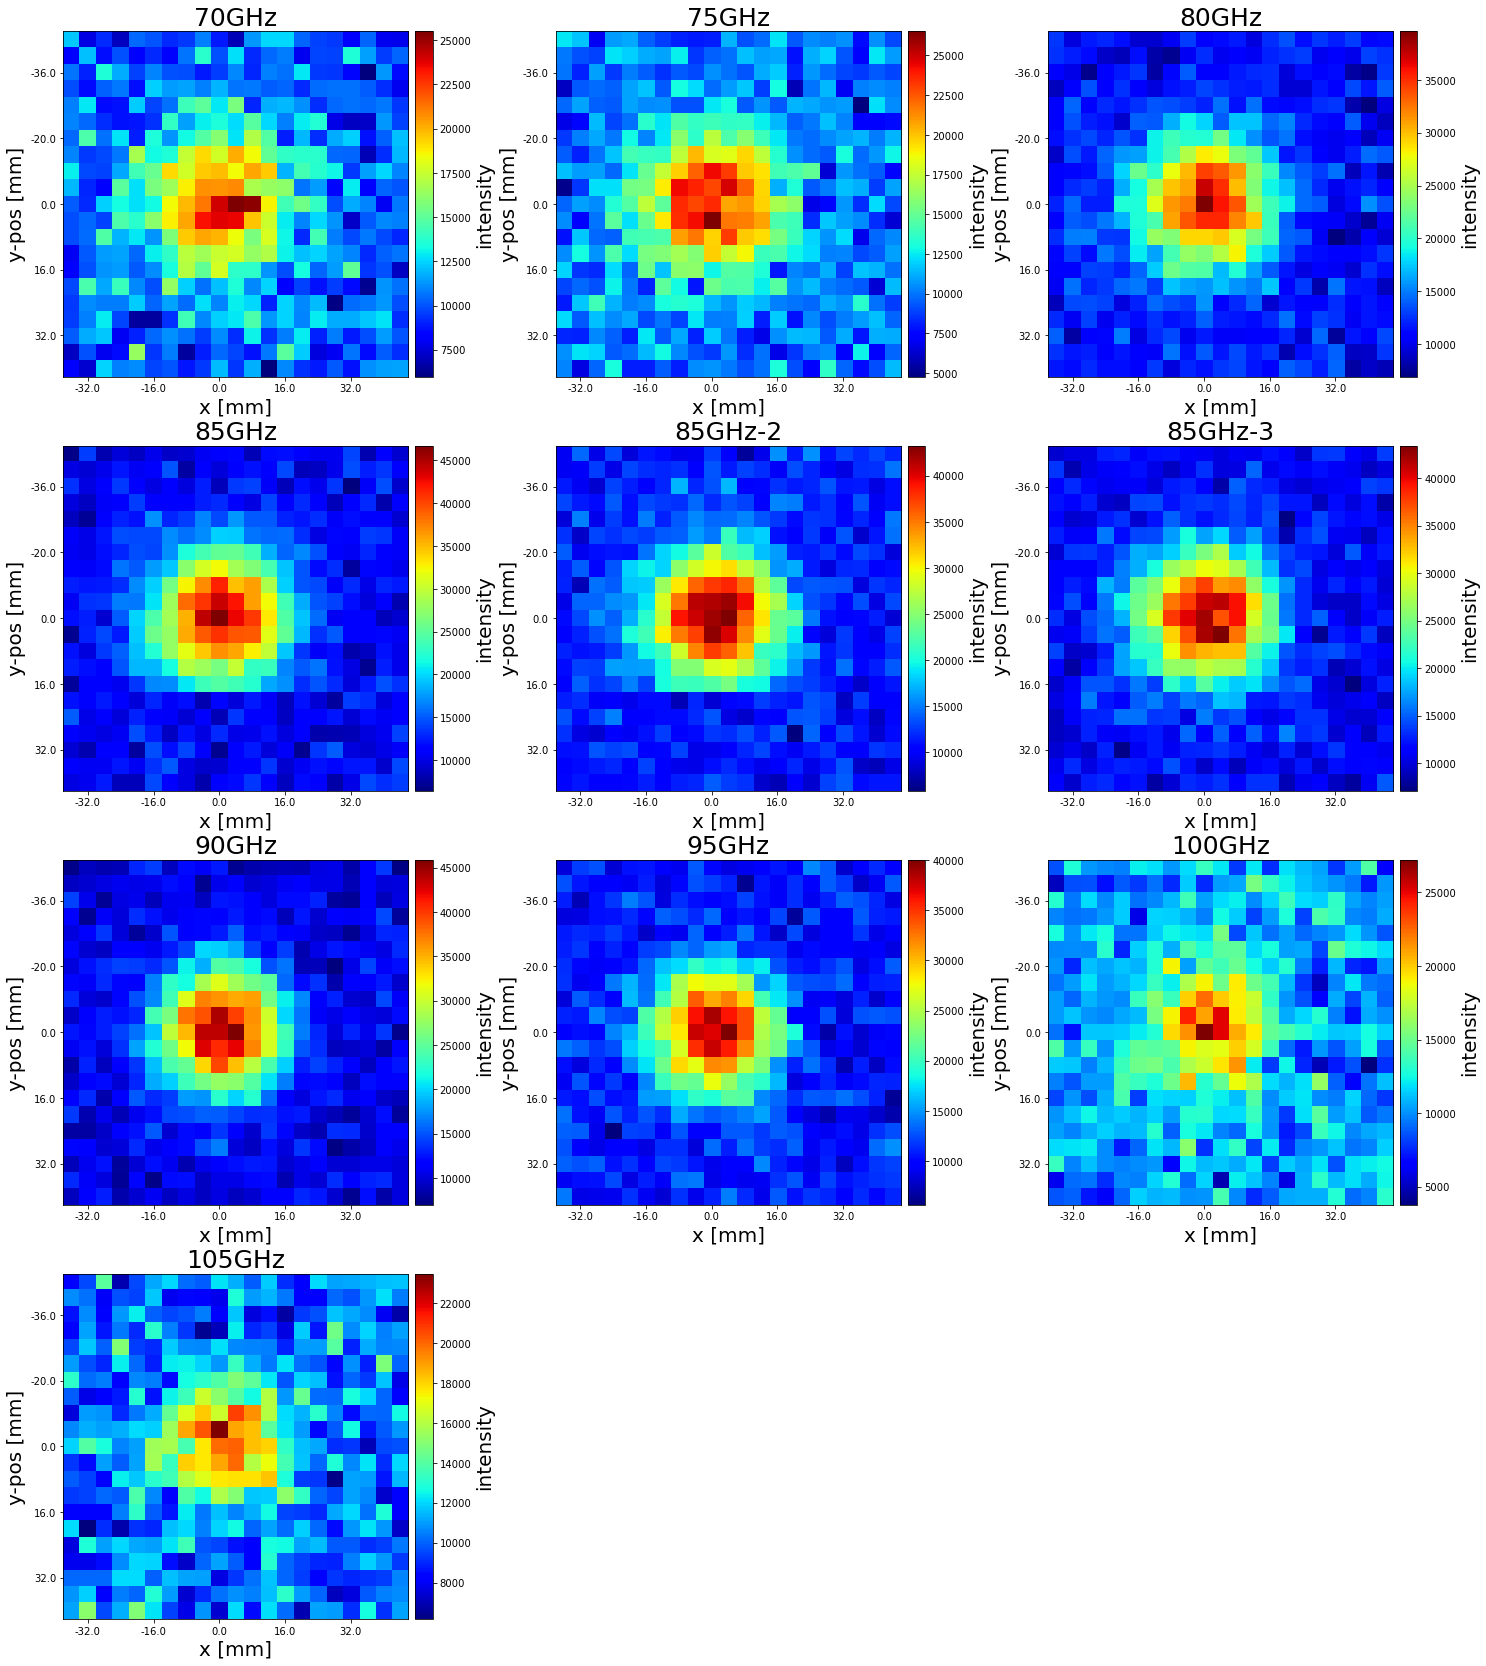

In [11]:
# in test_data
rows=int(len(paths) / 3) + (len(paths) % 3 > 0) # how many rows
# plot
fig = plt.figure(figsize=(25, 7.3*rows))
for i,image in enumerate(data):
    ax=plt.subplot(rows,3,i+1)
    im=ax.imshow(image[:,2].reshape((size,size)),cmap='jet', interpolation='nearest')
    # readjust labels to center
    # find x-peak
    peak_x=min(image[:,0][:size], key=lambda x:abs(x-popt_data[i][2]))
    index_x=list(image[:,0][:size]).index(peak_x)
    # y-peak
    peak_y=min(image[:,1][::size], key=lambda x:abs(x-popt_data[i][3]))
    index_y=list(image[:,1][::size]).index(peak_y)
    # xticks
    x_labs1=list(np.arange(-step_size*(index_x-1),0,step_size)[:-3][::4]) # lower labels
    x_labs2=list(np.arange(0,step_size*(size-index_x),step_size)[::4]) # upper labels
    ax.set_xticklabels(labels=x_labs1+x_labs2) # set labels
    x_ind1=list(np.arange(index_x,-1,-4)[1:][::-1]) # lower indices
    x_ind2=list(np.arange(index_x,size,4)) # upper indices
    ax.set_xticks(x_ind1+x_ind2) # set
    ax.set_xlabel("x [mm]",fontsize=20)
    # yticks
    y_labs1=list(np.arange(-step_size*(index_y-1),0,step_size)[:-3][::4]) # lower labels
    y_labs2=list(np.arange(0,step_size*(size-index_y),step_size)[::4]) # upper labels
    ax.set_yticklabels(labels=y_labs1+y_labs2) # set labels
    y_ind1=list(np.arange(index_y,-1,-4)[1:][::-1]) # lower indices
    y_ind2=list(np.arange(index_y,size,4)) # upper indices
    ax.set_yticks(y_ind1+y_ind2) # set indices
    ax.set_ylabel("y-pos [mm]",fontsize=20)
    ax.set_title(paths[i].name[:-4],fontsize=25)
    #adjust colorbar to plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar=plt.colorbar(im, cax=cax)
    cbar.ax.set_ylabel('intensity',fontsize=20)
# print current directory
print("current directory:\n{}".format(dir_names[menu.value]))

# Export

plt.savefig("Images/beam_maps/beam_maps_{}mm.png".format(dir_dist), bbox_inches='tight')

# Project find beam profile

current directory:
Distance 1650mm


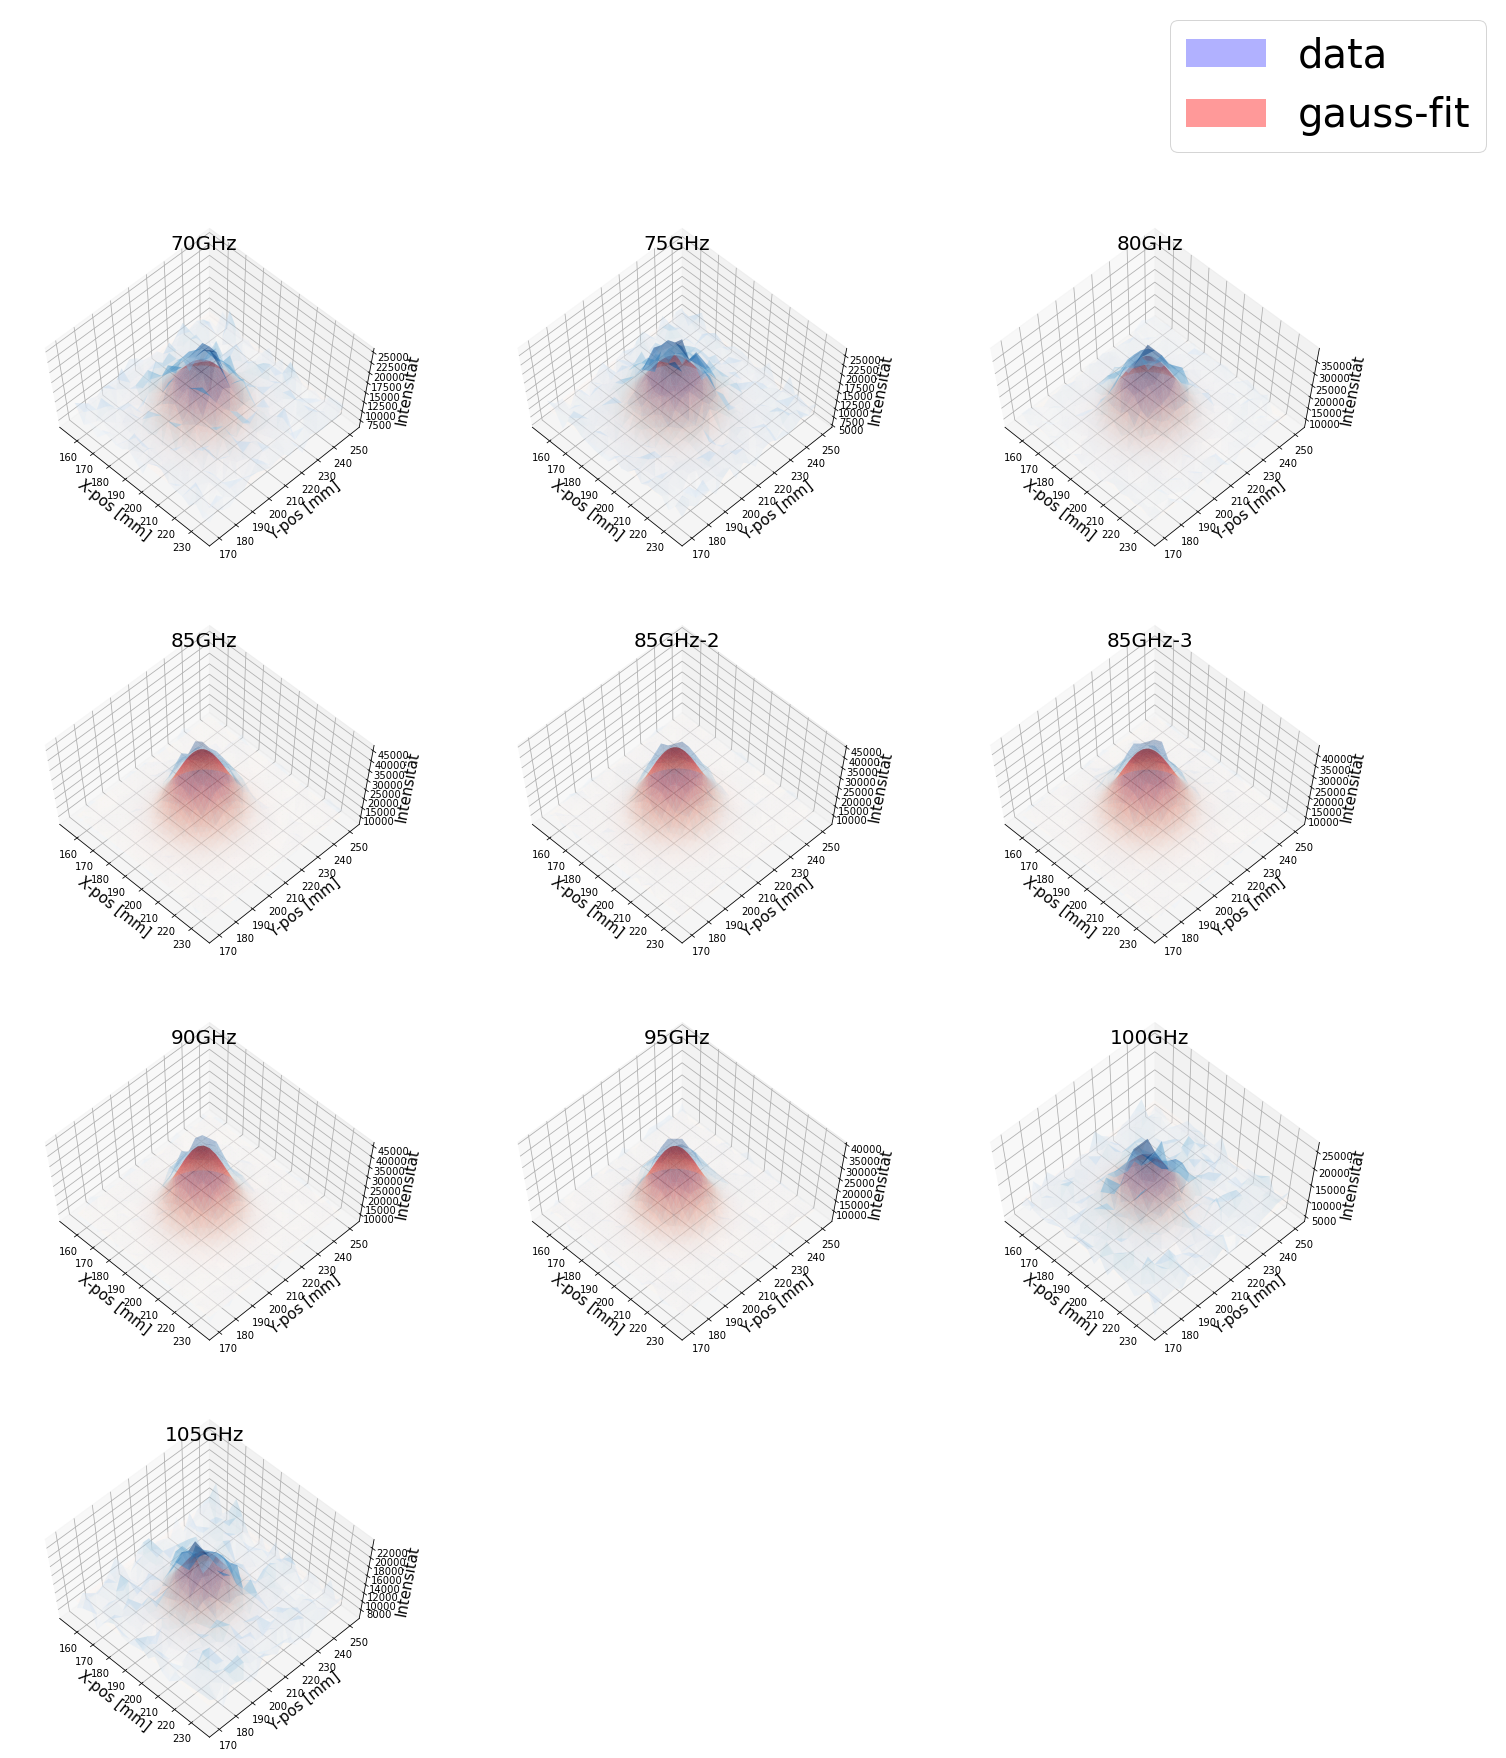

In [224]:
# plot the fits and functions in 3D (in coords space)
rows=int(len(popt_data) / 3) + (len(popt_data) % 3 > 0) # how many rows
fig = plt.figure(figsize=(24,rows*7))

for i,(popt,image) in enumerate(zip(popt_data,data)):
    X=np.linspace(np.amin(image[:,0]),np.amax(image[:,0]),50)
    Y=np.linspace(np.amin(image[:,1]),np.amax(image[:,1]),50)
    X_grid,Y_grid=np.meshgrid(X,Y)
    #plot
    ax = fig.add_subplot(rows,3,i+1, projection='3d')
    ax.set_xlabel('X-pos [mm]', fontsize=15)
    ax.set_ylabel('Y-pos [mm]', fontsize=15)
    ax.set_zlabel('Intensität', fontsize=15)
    Z=[gaussian_profile((x,y),popt=popt) for x in X for y in Y]
    ax.plot_trisurf(image[:,0], image[:,1], image[:,2], cmap='Blues',alpha=0.3)
    ax.plot_trisurf(X_grid.ravel(), Y_grid.ravel(), Z, cmap='Reds',alpha=0.4 )
    ax.set_title(paths[i].name[:-4], fontsize=20)
# legend
    blue_proxy = plt.Rectangle((0, 0), 1, 1, fc="Blue",alpha=0.3)
    red_proxy = plt.Rectangle((0, 0), 1, 1, fc="red",alpha=0.4)
    ax.view_init(65,-45) #angle of view
fig.legend([blue_proxy,red_proxy],['data','gauss-fit'],loc=1,prop={"size":40})
# print current directory
print("current directory:\n{}".format(dir_names[menu.value]))

# export

plt.savefig("Images/Gauss_fits_3D/Gauss_fits_3D_{}mm.png".format(dir_dist), bbox_inches='tight')

current directory:
Distance 1650mm


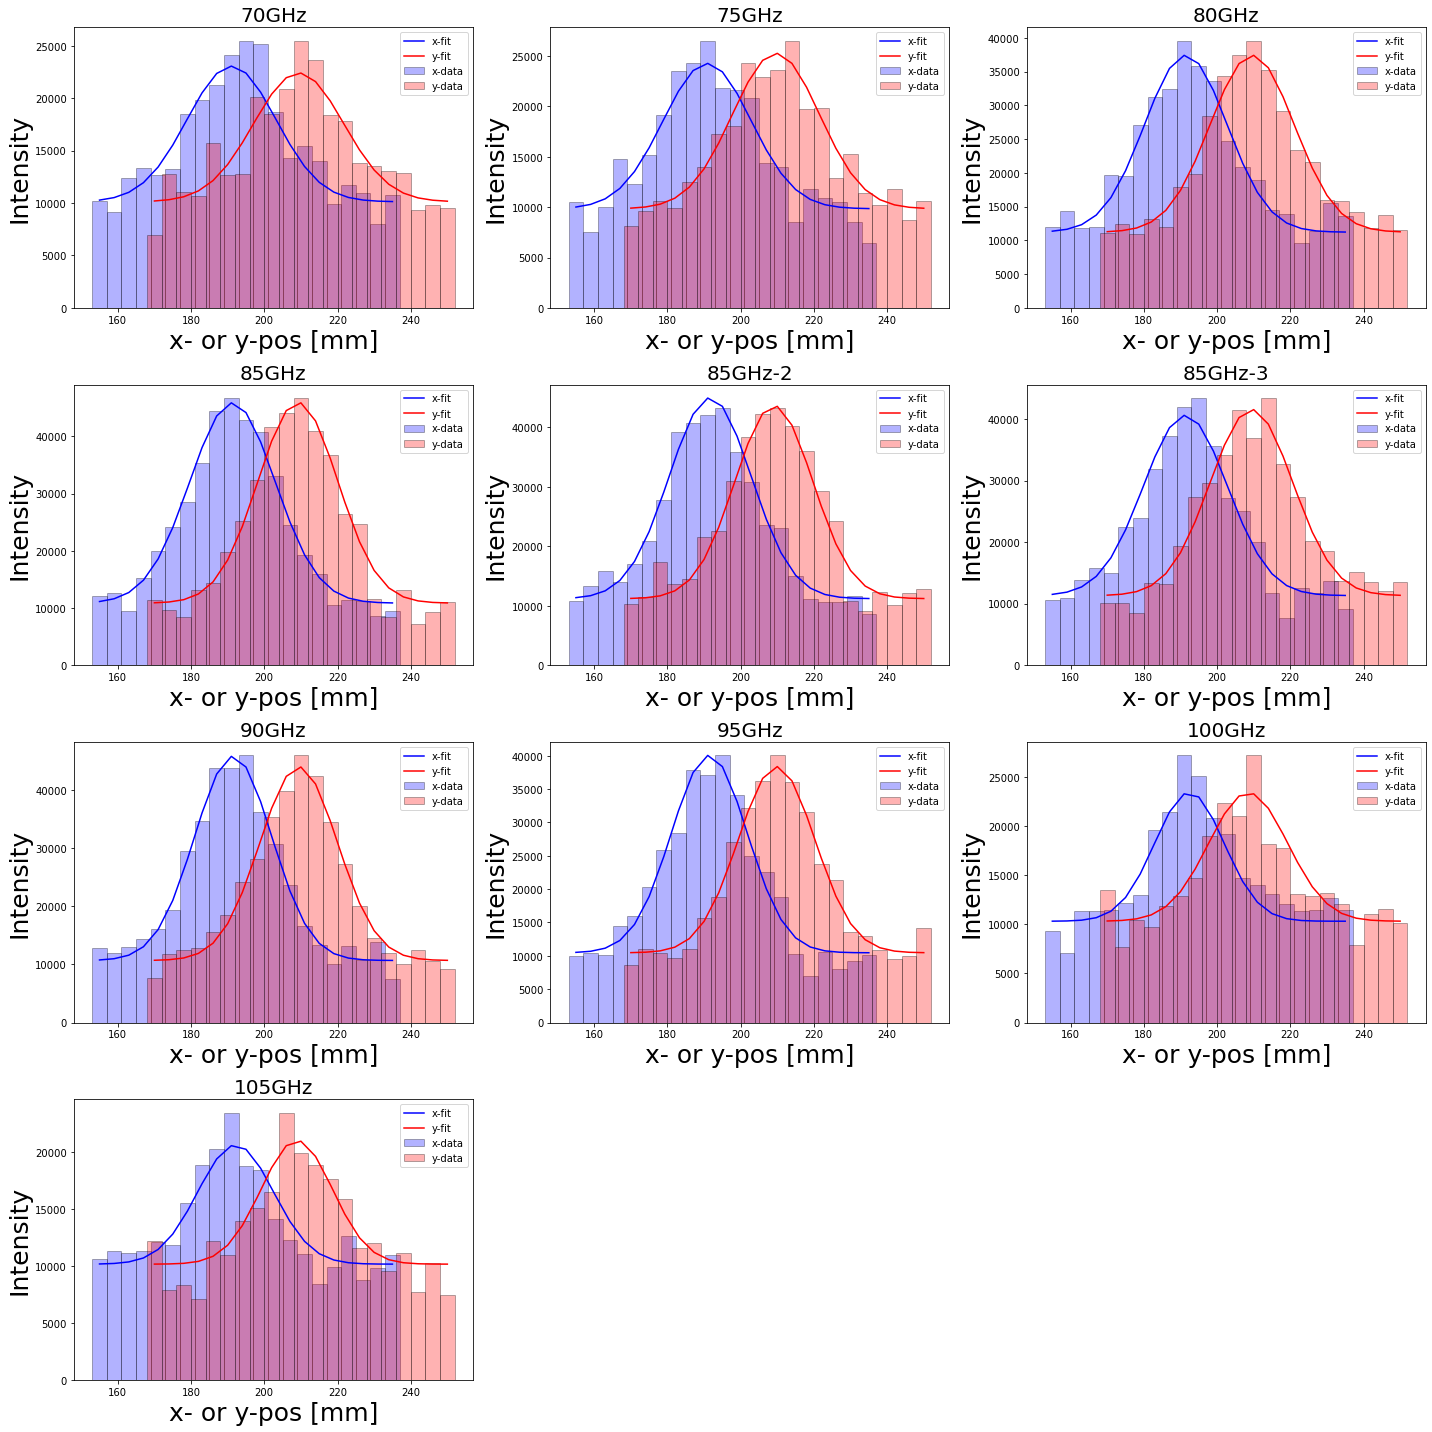

In [225]:
# plot the fits and functions
rows=int(len(popt_data) / 3) + (len(popt_data) % 3 > 0) # how many rows
fig = plt.figure(figsize=(20,rows*5))

for i,(popt,image) in enumerate(zip(popt_data,data)):
    #max positions
    max_pos=np.where(image[:,2]==np.amax(image[:,2]))[0][0]
    x_max=np.int(image[:,0][max_pos])
    y_max=np.int(image[:,1][max_pos])
    #plot
    ax = fig.add_subplot(rows,3,i+1)
    ax.set_xlabel('x- or y-pos [mm]', fontsize=25)
    ax.set_ylabel('Intensity', fontsize=25)
    ax.set_title(paths[i].name[:-4], fontsize=20)
    # x-plot
    X_vals=image[:,0][np.where(image[:,1]==y_max)]
    X_ints=image[:,2][np.where(image[:,1]==y_max)]
    X_fit=[gaussian_profile((x,y_max),popt=popt) for x in X_vals]
    plt.bar(X_vals,X_ints,width=4,color="blue",edgecolor="black",alpha=0.3,label="x-data")
    plt.plot(X_vals,X_fit,color="blue",label="x-fit")
    # y_plot
    Y_vals=image[:,1][np.where(image[:,0]==x_max)]
    Y_ints=image[:,2][np.where(image[:,0]==x_max)]
    Y_fit=[gaussian_profile((x_max,y),popt=popt) for y in Y_vals]
    plt.bar(Y_vals,Y_ints,width=4,color="red",edgecolor="black",alpha=0.3,label="y-data")
    plt.plot(Y_vals,Y_fit,color="red",label="y-fit")
    plt.legend(prop={"size":10})
plt.tight_layout()
# print current directory
print("current directory:\n{}".format(dir_names[menu.value]))

# export

plt.savefig("Images/Gauss_fits_xy/Gauss_fits_xy_{}mm.png".format(dir_dist), bbox_inches='tight')

In [226]:
# create Pandas DataFrame
popt_array=np.array(popt_data)
pcov_array=np.array(pcov_data)
total_array=np.zeros(shape=(popt_array.shape[0],popt_array.shape[1]*2))
for i in range(0,total_array.shape[1]):
    if i%2==0:
        total_array[:,i]=popt_array[:,np.int(i/2)]
    else:
        total_array[:,i]=pcov_array[:,np.int((i-1)/2)]
#DataFrame initialization
fit_results=pd.DataFrame(total_array,index=list(map(lambda x: x.name[:-4], paths)),
                     columns=["A","ΔA","b","Δb","x_0","Δx_0","y_0","Δy_0","σ_x","Δσ_x","σ_y","Δσ_y","θ","Δθ"]).round(decimals=2)
fit_results["θ"],fit_results["Δθ"]=(fit_results["θ"]%(2*np.pi)).round(decimals=2),(fit_results["Δθ"]%(2*np.pi)).round(decimals=2)
# print current directory
print("current directory:\n{}".format(dir_names[menu.value]))

fit_results

current directory:
Distance 1650mm


,A,ΔA,b,Δb,x_0,Δx_0,y_0,Δy_0,σ_x,Δσ_x,σ_y,Δσ_y,θ,Δθ
70GHz,12948.9000,448.6000,10125.9000,118.5400,191.0800,0.4200,209.6300,0.4300,12.6100,0.4900,11.8800,0.4600,4.0300,0.4100
75GHz,15430.0600,443.1900,9839.6100,111.9100,190.8800,0.3400,209.6400,0.3400,11.8800,0.3800,12.0400,0.3900,5.1500,1.4700
80GHz,26239.4800,477.8000,11222.1200,110.7500,191.4600,0.2100,209.5700,0.2100,11.5400,0.2300,11.2900,0.2300,4.4300,0.6000
85GHz,35136.1600,550.5400,10856.7300,125.1600,191.3300,0.1800,209.1700,0.1700,11.7100,0.2000,10.9000,0.1900,0.2100,0.1500
85GHz-2,33934.4800,563.8200,11199.3600,121.6000,191.6800,0.1900,209.1000,0.1800,11.2600,0.2000,10.6600,0.1900,0.1300,0.2200
85GHz-3,31870.5600,482.7100,11311.9600,111.7200,191.3100,0.1700,209.3700,0.1700,11.3100,0.1900,11.5100,0.1900,1.3600,0.6000
90GHz,35162.3400,526.7600,10658.5100,107.3600,191.5200,0.1600,209.4200,0.1600,10.5400,0.1700,10.6500,0.1700,5.9900,1.0100
95GHz,29630.0700,555.0500,10455.1600,110.2900,191.4300,0.1900,209.7500,0.2000,10.5300,0.2100,10.3300,0.2100,2.0200,0.6800
100GHz,13272.9700,620.3800,10324.5900,117.2900,192.4800,0.4400,208.4500,0.5000,9.4700,0.4700,10.8000,0.5400,3.0400,0.2500
105GHz,10948.3700,529.4100,10163.9300,98.9600,192.1900,0.5000,208.8800,0.4700,9.7400,0.5000,10.3500,0.5300,4.6700,0.5600


In [227]:
# In the following we assume that σ_x=σ_y und therefore take the average:
total_results=pd.DataFrame([(fit_results["σ_x"]+fit_results["σ_y"])/2,
                            np.sqrt((fit_results["Δσ_x"]**2+fit_results["Δσ_y"]**2))/2],
                           index=["σ","Δσ"]).T.round(decimals=2)
total_results["ω_z"]=2*total_results["σ"]
total_results["Δω_z"]=2*total_results["Δσ"]
# print current directory
print("current directory:\n{}".format(dir_names[menu.value]))

total_results

current directory:
Distance 1650mm


,σ,Δσ,ω_z,Δω_z
70GHz,12.2400,0.3400,24.4800,0.6800
75GHz,11.9600,0.2700,23.9200,0.5400
80GHz,11.4200,0.1600,22.8400,0.3200
85GHz,11.3000,0.1400,22.6000,0.2800
85GHz-2,10.9600,0.1400,21.9200,0.2800
85GHz-3,11.4100,0.1300,22.8200,0.2600
90GHz,10.6000,0.1200,21.2000,0.2400
95GHz,10.4300,0.1500,20.8600,0.3000
100GHz,10.1400,0.3600,20.2800,0.7200
105GHz,10.0400,0.3600,20.0800,0.7200


# Comparison with noise temperature

In [228]:
temp=np.array((noise["T_R"].replace([np.inf, -np.inf], np.nan).dropna(axis=0)))
index_max = max(range(len(temp)), key=temp.__getitem__)

current directory:
Distance 1650mm


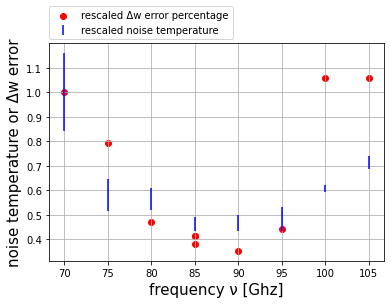

In [229]:
T_hot=293
T_cold=77

noise=pd.DataFrame({"P_H":[0.167,0.168,0.228,0.280,0.236,0.166,0.0757,0.0572,0.0144],"P_C":[0.147,0.137,0.185,0.219,0.185,0.131,0.0622,0.0482,0.0144],"ΔP":6*[0.002]+3*[0.0002]},index=[70,75,80,85,90,95,100,105,110])
noise.index.name="ν in Ghz"
noise["γ"]=noise["P_H"]/noise["P_C"]
noise["Δγ"]=np.sqrt((noise["ΔP"]/noise["P_C"])**2+((noise["P_H"]*noise["ΔP"])/noise["P_C"]**2)**2)
noise["T_R"]=(T_hot-noise["γ"]*T_cold)/(noise["γ"]-1)
noise["ΔT_R"]= np.sqrt(((T_hot/(noise["P_H"]-noise["P_C"])+(noise["P_C"]*T_hot-noise["P_H"]*T_cold)/(noise["P_H"]-noise["P_C"])**2)*noise["ΔP"])**2 + ((T_cold/(noise["P_H"]-noise["P_C"])+(noise["P_C"]*T_hot-noise["P_H"]*T_cold)/(noise["P_H"]-noise["P_C"])**2)*noise["ΔP"])**2)
# only compare with available frequencies
noise=noise.loc[np.unique(freq_list) , :]
# find max index
temp=np.array((noise["T_R"].replace([np.inf, -np.inf], np.nan).dropna(axis=0)))
index_max = max(range(len(temp)), key=temp.__getitem__)
rescaling=temp[index_max]
del temp
# note that this uses the measured, not the readjusted scaling
plt.errorbar(noise.index,noise["T_R"]/rescaling,noise["ΔT_R"]/rescaling,color="blue",linestyle="",label="rescaled noise temperature")
plt.scatter(freq_list,total_results["Δω_z"]/total_results["Δω_z"][0],color="Red",label="rescaled Δw error percentage")
plt.xlabel("frequency ν [Ghz]",fontsize=15)
plt.ylabel("noise temperature or Δw error",fontsize=15)
plt.grid(True)
plt.legend(bbox_to_anchor=(0, 1.17), loc='upper left', borderaxespad=0.)
# print current directory
print("current directory:\n{}".format(dir_names[menu.value]))

# export
plt.savefig("Images/comp_noise/noise_comp_{}mm.png".format(dir_dist), bbox_inches='tight')

# Comparison of theory and experiment

## Standard Calculation


current directory:
Distance 1650mm


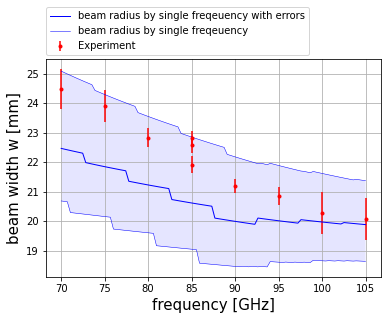

In [230]:
# find all frequencies in our data
frequencies=np.unique(freq_list) # in GHz
# error bars
freq_range=np.linspace(min(frequencies),max(frequencies),100)
# # # # # # # #
d_in_err=10
d_mirr_device=15
X_err=np.sqrt((d_in_err)**2+(d_mirr_device)**2)
foc_err=0
freq_err=1.25
err_precision=1
# # # # # # # # 
X_bar=np.arange(dir_dist-X_err,dir_dist+X_err+err_precision,err_precision)
d_in_bar=np.arange(d_in-d_in_err,d_in+d_in_err+err_precision,err_precision)
foc_bar=np.arange(foc-foc_err,foc+foc_err+err_precision,err_precision)
error_area=np.zeros((len(X_bar)*len(d_in_bar)*len(np.arange(freq-freq_err,freq+freq_err+err_precision,err_precision))*len(foc_bar),len(freq_range)))
# # # # # # # #
for i,freq in tqdm(enumerate(freq_range),total=len(freq_range),desc="progress"):
    j=0
    freq_bar=np.arange(freq-freq_err,freq+freq_err+err_precision,err_precision)
    for err_X in X_bar:
        for err_d_in in d_in_bar:
            for err_foc in foc_bar:
                for err_freq in freq_bar:
                    error_area[j,i]=create_plot(X=err_X, d_in=err_d_in,ω_0_in=ω_0_in_list[min(ω_0_in_list.keys(), key=lambda x:abs(x-err_freq))],foc=err_foc,λ=c/(err_freq*1E9))
                    j+=1
#plot experimental data
ax=plt.subplot(111)
ax.errorbar(freq_list,np.array(total_results["ω_z"]),linestyle="",
             yerr=np.array(total_results["Δω_z"]), color="red",marker=".",label="Experiment")
# plot theory data without errors
clean_theory=[create_plot(X=dir_dist, d_in=d_in,ω_0_in=ω_0_in_list[min(ω_0_in_list.keys(), key=lambda x:abs(x-freq))],foc=foc,λ=c/(freq*1E9)) for freq in freq_range]
ax.plot(freq_range,clean_theory,color="blue",linewidth=1, label="beam radius by single freqeuency with errors")
#plot error
ax.plot(freq_range,error_area.max(axis=0), color="blue",linewidth=0.5, label="beam radius by single freqeuency")
ax.plot(freq_range,error_area.min(axis=0), color="blue",linewidth=0.5)
ax.fill_between(freq_range, error_area.max(axis=0), error_area.min(axis=0), facecolor='blue', interpolate=True,alpha=0.1)
# legend
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[2][0],handles[1],handles[0]],labels[::-1],loc='upper right', numpoints=1)
#ax.set_title("Comparison between Theory and Experiment",fontsize=15)
ax.set_xlabel("frequency [GHz]",fontsize=15)
ax.set_ylabel("beam width w [mm]",fontsize=15)
ax.grid(True) # activate grid in plot
plt.legend(bbox_to_anchor=(0, 1.24), loc='upper left', borderaxespad=0.)
# print current directory
print("current directory:\n{}".format(dir_names[menu.value]))

# export

plt.savefig("Images/comp_standard/comp_standard_{}mm.png".format(dir_dist), bbox_inches='tight')

## Heterodyne Calculation

### With errors, but less frequencies in band


current directory:
Distance 1650mm


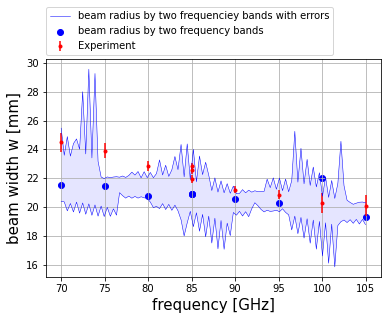

In [231]:
frequencies=np.unique(freq_list) # in GHz
# error bars
freq_range=np.linspace(min(frequencies),max(frequencies),100)
# # # # # # # #
d_in_err=10
d_mirr_device=15
X_err=np.sqrt((d_in_err)**2+(d_mirr_device)**2)
foc_err=0
freq_err=0
err_precision=5
band=20
# # # # # # # # 
X_bar=np.arange(dir_dist-X_err,dir_dist+X_err+err_precision,err_precision)
d_in_bar=np.arange(d_in-d_in_err,d_in+d_in_err+err_precision,err_precision)
foc_bar=np.arange(foc-foc_err,foc+foc_err+err_precision,err_precision)
error_area=np.zeros((len(X_bar)*len(d_in_bar)*len(np.arange(freq-freq_err,freq+freq_err+err_precision,err_precision))*len(foc_bar),len(freq_range)))
# # # # # # # #
for i,freq in tqdm(enumerate(freq_range),total=len(freq_range),desc="total progress"):
    j=0
    freq_bar=np.arange(freq-freq_err,freq+freq_err+err_precision,err_precision)
    for err_X in tqdm(X_bar,leave=False):
        for err_d_in in d_in_bar:
            for err_foc in foc_bar:
                for err_freq in freq_bar:
                    # Caculation
                    X_a=list(np.linspace(err_freq-6.35-1.25,err_freq-6.35+1.25,band)) + list(np.linspace(err_freq+6.35-1.25,err_freq+6.35+1.25,band))
                    X_b=[1/len(X_a)]*len(X_a)
                    error_area[j,i]=I_comb(err_X, f_list=X_a, A_0_list=X_b,d_in=err_d_in,foc=err_foc,c=c,ω_0_in_list=ω_0_in_list)
                    j+=1
#plot experimental data
ax=plt.subplot(111)
ax.errorbar(freq_list,np.array(total_results["ω_z"]),linestyle="",
             yerr=np.array(total_results["Δω_z"]), color="red",marker=".",label="Experiment")
# plot theory data without errors
X_a=[list(np.linspace(x-6.35-1.25,x-6.35+1.25,band))+list(np.linspace(x+6.35-1.25,x+6.35+1.25,band)) for x in freq_list]
X_b=[[1/len(X_a[0])]*len(X_a[0])]*len(X_a)
Y=[I_comb(dir_dist, f_list=X_a[i], A_0_list=X_b[i],d_in=d_in,foc=foc,c=c,ω_0_in=ω_0_in) for i in tqdm(range(len(X_a)))]
ax.scatter(freq_list,Y,color="blue", label="beam radius by two frequency bands")
#plot error
ax.plot(freq_range,error_area.max(axis=0), color="blue",linewidth=0.5, label="beam radius by two frequenciey bands with errors")
ax.plot(freq_range,error_area.min(axis=0), color="blue",linewidth=0.5)
ax.fill_between(freq_range, error_area.max(axis=0), error_area.min(axis=0), facecolor='blue', interpolate=True,alpha=0.1)
# legend
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[2][0],handles[1],handles[0]],labels[::-1],loc='upper right', numpoints=1)
#ax.set_title("Comparison between Theory and Experiment",fontsize=15)
ax.set_xlabel("frequency [GHz]",fontsize=15)
ax.set_ylabel("beam width w [mm]",fontsize=15)
ax.grid(True)
plt.legend(bbox_to_anchor=(0, 1.24), loc='upper left', borderaxespad=0.)
# print current directory
print("current directory:\n{}".format(dir_names[menu.value]))

# export

plt.savefig("Images/comp_heterodyne/comp_heterodyne_{}mm.png".format(dir_dist), bbox_inches='tight')

# Comparison between both methods of beam radius calculation


current directory:
Distance 1650mm


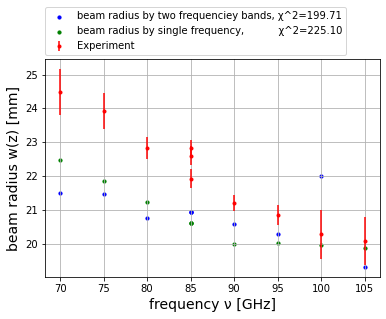

In [232]:
# rest
band=20 # elements per band (discrete approximation for continuous value)

# Caculation
X_a=[list(np.linspace(x-6.35-1.25,x-6.35+1.25,band))+list(np.linspace(x+6.35-1.25,x+6.35+1.25,band)) for x in freq_list]
X_b=[[1/len(X_a[0])]*len(X_a[0])]*len(X_a)
Y_1=[I_comb(dir_dist, f_list=X_a[i], A_0_list=X_b[i],d_in=d_in,foc=foc,c=c,ω_0_in_list=ω_0_in_list) for i in tqdm(range(len(X_a)))]
Y_2=[create_plot(X=dir_dist, d_in=d_in,ω_0_in=ω_0_in_list[min(ω_0_in_list.keys(), key=lambda x:abs(x-freq))],foc=foc,λ=c/(freq*1E9)) for freq in freq_list]
ax= plt.subplot(1,1,1)
Y_1_chi_sqaured=sum((np.array(total_results["ω_z"])-Y_1)**2/np.array(total_results["Δω_z"])**2)
ax.scatter(freq_list,Y_1,color="blue",s=10,label="beam radius by two frequenciey bands, χ^2={:.2f}".format(Y_1_chi_sqaured))
Y_2_chi_sqaured=sum((np.array(total_results["ω_z"])-Y_2)**2/np.array(total_results["Δω_z"])**2)
ax.scatter(freq_list,Y_2,color="green",s=10,label="beam radius by single frequency,           χ^2={:.2f}".format(Y_2_chi_sqaured))
ax.errorbar(freq_list,np.array(total_results["ω_z"]),linestyle="",
             yerr=np.array(total_results["Δω_z"]), color="red",marker=".",label="Experiment")
ax.set_xlabel("frequency ν [GHz]",fontsize=14)
ax.set_ylabel("beam radius w(z) [mm]",fontsize=14)
ax.grid(True) # activate grid in plot
plt.legend(bbox_to_anchor=(0, 1.24), loc='upper left', borderaxespad=0.)
# print current directory
print("current directory:\n{}".format(dir_names[menu.value]))

# export

plt.savefig("Images/comp_both/comp_both_{}mm.png".format(dir_dist), bbox_inches='tight')